In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.nn.functional import avg_pool2d
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM as FlatLambdaCDM_AP
from astropy.cosmology import default_cosmology
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import caustics

In [2]:
def setup_grids(res=0.05, n_pix=100, device=None):
    # Caustics setup
    thx, thy = caustics.utils.meshgrid(res, n_pix, device=device)
    if device is not None:
        thx = thx.to(device=device)
        thy = thy.to(device=device)

    # Lenstronomy setup
    fov = res * n_pix
    ra_at_xy_0, dec_at_xy_0 = ((-fov + res) / 2, (-fov + res) / 2)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * res
    kwargs_pixel = {
        "nx": n_pix,
        "ny": n_pix,  # number of pixels per axis
        "ra_at_xy_0": ra_at_xy_0,
        "dec_at_xy_0": dec_at_xy_0,
        "transform_pix2angle": transform_pix2angle,
    }
    pixel_grid = PixelGrid(**kwargs_pixel)
    thx_ls, thy_ls = pixel_grid.coordinate_grid(n_pix, n_pix)
    return thx, thy, thx_ls, thy_ls

In [3]:
# Parameters
z_l = torch.tensor(0.5)
z_s = torch.tensor(1.5)
m = 1e10
c = 8.0
t = 5.0

cosmology = caustics.FlatLambdaCDM(name="cosmo")
lens = caustics.TNFW(
    name="tnfw", cosmology=cosmology, z_l=z_l, interpret_m_total_mass=False
)

lens_model_list = ["TNFW"]
lens_ls = LensModel(lens_model_list=lens_model_list)

thx0 = 0.457
thy0 = 0.141
x = torch.tensor([thx0, thy0, m, c, t])

# Lenstronomy
h0_default = float(default_cosmology.get().h)
Om0_default = float(default_cosmology.get().Om0)
Ob0_default = float(default_cosmology.get().Ob0)
cosmo = FlatLambdaCDM_AP(H0=h0_default * 100, Om0=Om0_default, Ob0=Ob0_default)
lens_cosmo = LensCosmo(z_lens=z_l.item(), z_source=z_s.item(), cosmo=cosmo)
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)
x[3] = Rs_angle

# lenstronomy params ['Rs', 'alpha_Rs', 'center_x', 'center_y']
kwargs_ls = [
    {
        "Rs": Rs_angle,
        "alpha_Rs": alpha_Rs,
        "r_trunc": Rs_angle * t,
        "center_x": thx0,
        "center_y": thy0,
    }
]

In [4]:
thx, thy, thx_ls, thy_ls = setup_grids()
Psi = lens.potential(thx, thy, z_s, x)
Psi_ls = lens_ls.potential(thx_ls, thy_ls, kwargs_ls)
# Potential is only defined up to a constant
# Psi -= Psi.min()
# Psi_ls -= Psi_ls.min()

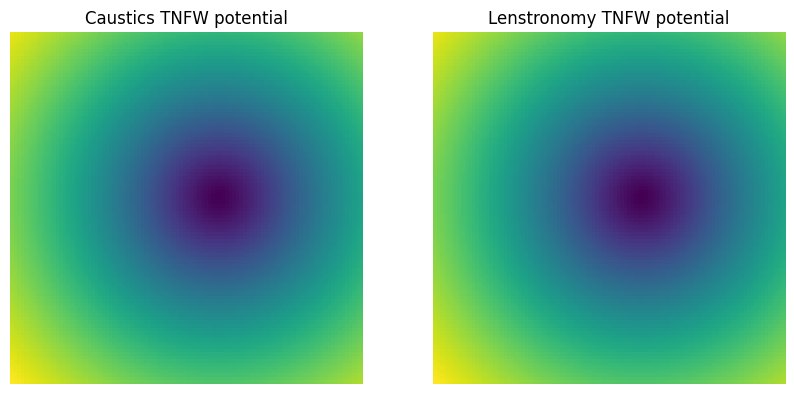

In [5]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(Psi.cpu().numpy(), origin="lower")
axarr[0].set_title("Caustics TNFW potential")
axarr[0].axis("off")
axarr[1].imshow(Psi_ls, origin="lower")
axarr[1].set_title("Lenstronomy TNFW potential")
axarr[1].axis("off")
plt.show()

In [6]:
def F_where(x):
    """
    Compute the function F(x) for a TNFW profile.

    Helper method from Baltz et al. 2009 equation A.5
    """
    x_gt1 = torch.clamp(x, min=1 + 1e-6)
    x_lt1 = torch.clamp(x, max=1 - 1e-6)
    return torch.where(
        x < 1 - 1e-6,
        torch.log(1 / x_lt1 + (1 / x_lt1**2 - 1).sqrt()) / (1.0 - x_lt1**2).sqrt(),
        torch.where(
            x > 1 + 1e-6,
            torch.arccos(1 / x_gt1) / (x_gt1**2 - 1.0).sqrt(),
            torch.ones_like(x),  # where: x == 1
        ),
    )

def F_arccosh(x):
    """
    Compute the function F(x) for a TNFW profile.

    Helper method from Baltz et al. 2009 equation A.5
    """
    x_gt1 = torch.clamp(x, min=1 + 1e-3)
    x_lt1 = torch.clamp(x, max=1 - 1e-3)
    return torch.where(
        x < 1 - 1e-2,
        torch.arccosh(1 / x_lt1) / (1.0 - x_lt1**2).sqrt(),
        torch.where(
            x > 1 + 1e-2,
            torch.arccos(1 / x_gt1) / (x_gt1**2 - 1.0).sqrt(),
            1 - 2*(x-1)/3 + 7*(x-1)**2 / 15,  # where: x == 1
        ),
    )

def F_complex(x):
    return (
        ((1 / x.to(dtype=torch.cdouble)).arccos() / (x.to(dtype=torch.cdouble) ** 2 - 1).sqrt())
        .conj().abs()
        .to(dtype=x.dtype)
    )


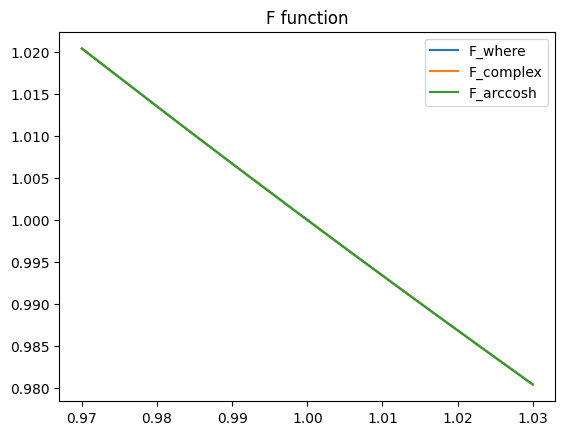

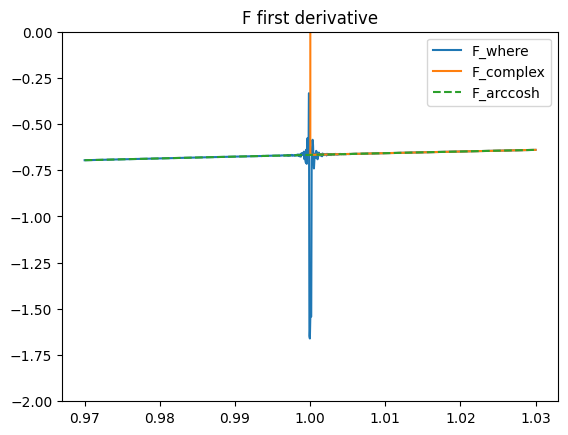

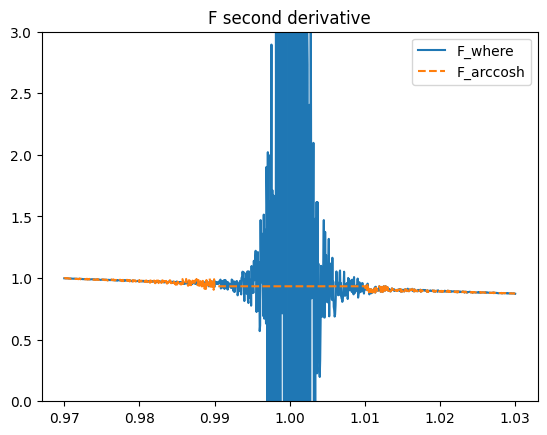

In [7]:
x = torch.linspace(0.97, 1.03, 1000)
plt.plot(x, F_where(x), label="F_where")
plt.plot(x, F_complex(x), label="F_complex")
plt.plot(x, F_arccosh(x), label="F_arccosh")
plt.title("F function")
plt.legend()
plt.show()

plt.plot(x, torch.vmap(torch.func.grad(F_where))(x), label="F_where")
plt.plot(x, torch.vmap(torch.func.grad(F_complex))(x), label="F_complex")
plt.plot(x, torch.vmap(torch.func.grad(F_arccosh))(x), label="F_arccosh", linestyle='--')
plt.title("F first derivative")
plt.ylim([-2,0])
plt.legend()
plt.show()

plt.plot(x, torch.vmap(torch.func.grad(torch.func.grad(F_where)))(x), label="F_where")
# plt.plot(x, torch.vmap(torch.func.grad(F_complex))(x), label="F_complex")
plt.plot(x, torch.vmap(torch.func.grad(torch.func.grad(F_arccosh)))(x), label="F_arccosh", linestyle='--')
plt.title("F second derivative")
plt.ylim([-0,3])
plt.legend()
plt.show()

In [46]:
def P_where(x):
    """
    Compute the function F(x) for a TNFW profile.

    Helper method from Baltz et al. 2009 equation A.5
    """
    x_gt1 = torch.clamp(x, min=1 + 1e-3)
    x_lt1 = torch.clamp(x, max=1 - 1e-3)
    return torch.where(
        x < 1 - 1e-2,
        -torch.arccosh(1 / x_lt1) ** 2,
        torch.where(
            x > 1 + 1e-2,
            torch.arccos(1 / x_gt1) ** 2,
            (2 * (x - 1) - 5*(x-1)**2 / 3) ,  # where: x == 1 # fixme
        ),
    )

def P_complex(x):
    return (
        ((1 / x.to(dtype=torch.cdouble)).arccos()**2)
        
        .to(dtype=x.dtype)
    )

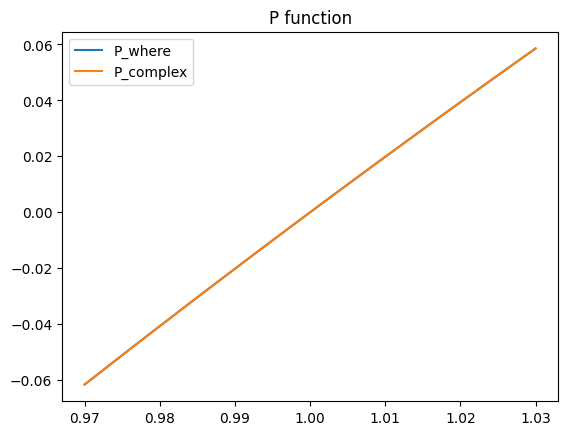

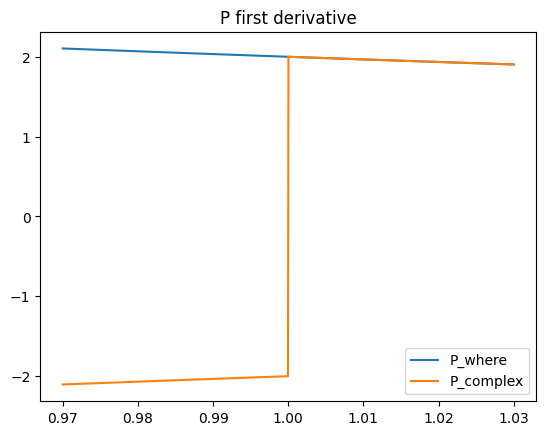

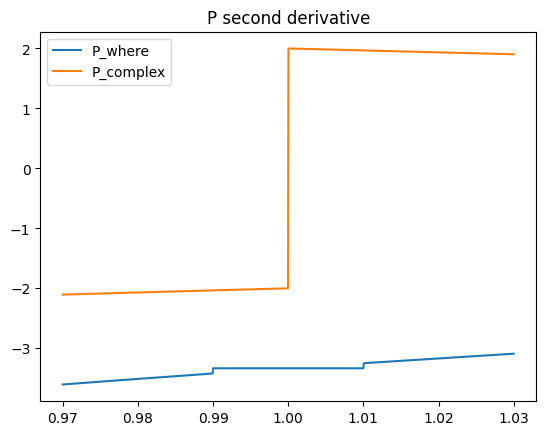

In [47]:
x = torch.linspace(0.97, 1.03, 1000)
plt.plot(x, P_where(x), label="P_where")
plt.plot(x, P_complex(x), label="P_complex")
plt.title("P function")
plt.legend()
plt.show()

plt.plot(x, torch.vmap(torch.func.grad(P_where))(x), label="P_where")
plt.plot(x, torch.vmap(torch.func.grad(P_complex))(x), label="P_complex")
plt.title("P first derivative")
# plt.ylim([-2,0])
plt.legend()
plt.show()

plt.plot(x, torch.vmap(torch.func.grad(torch.func.grad(P_where)))(x), label="P_where")
plt.plot(x, torch.vmap(torch.func.grad(P_complex))(x), label="P_complex")
plt.title("P second derivative")
# plt.ylim([-0,3])
plt.legend()
plt.show()